In [1]:
%load_ext autoreload
%autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
import itertools
from sklearn.metrics import mean_absolute_error as mae
import random
from random import randint
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
import pickle
import datetime
from mlopt.ACO import ACO
from mlopt.AGMLP_Residual import AGMLP_Residual
from mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.AGEnsemble_Residual import AGEnsemble_Residual
from mlopt.TimeSeriesUtils import *
import copy

warnings.filterwarnings("ignore")

# Data Correction Functions

In [2]:
def correct_apac(df_in, hour_range=(5,19)):
    
    df_apac = df_in.copy()
    df_apac = df_apac[df_apac.dia != "dia"]
    
    df_apac['Datetime']=pd.to_datetime(df_apac.dia.apply(str)+"/"+df_apac.mes.apply(str)+"/"+\
                                       df_apac.ano.apply(str), format="%d/%b/%Y")+\
                                       df_apac['hora(utc)'].apply(lambda x: datetime.timedelta(hours=int(x)))
    
    df_apac.drop_duplicates(subset="Datetime", inplace=True)
    
    inicio = datetime.datetime.strptime("01/"+str(df_apac.Datetime.iloc[0].month)+"/"+\
            str(df_apac.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
    
    fim = df_apac.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')
    
    #print(len(df_apac), len(df_apac.Datetime.unique()))
    
    df_apac = df_apac.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
    df_apac = df_apac[df_apac['hora(utc)'].isin(range(hour_range[0], hour_range[1]))]
    df_apac.drop(['ano','mes', 'dia', 'hora(utc)'],inplace=True,axis = 1)# drop duplicate infomation
        
    return df_apac

def correct_inmet(df_in, hour_range=(5,19)):
    
    df_inmet = df_in.copy()
    df_inmet.replace('////', np.nan, inplace=True)
    
    columns_to_numeric = list(set(df_inmet.columns) - set(["codigo_estacao","data","hora","planta"]))
        
    df_inmet[columns_to_numeric] = df_inmet[columns_to_numeric].apply(pd.to_numeric)
    df_inmet['Datetime']=pd.to_datetime(df_inmet.data, format="%d/%m/%Y")\
                    +df_inmet.hora.apply(lambda x: datetime.timedelta(hours=x))
    
    inicio = datetime.datetime.strptime("01/"+str(df_inmet.Datetime.iloc[0].month)+"/"+\
            str(df_inmet.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
        
    fim = df_inmet.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')

    df_inmet = df_inmet.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
    
    df_inmet = df_inmet[df_inmet['hora'].isin(range(hour_range[0], hour_range[1]))]
    df_inmet.drop(['data','hora'],inplace=True,axis = 1)# drop duplicate infomation
     
    return df_inmet

def correct_gen(df_in, hour_range=(5,19)):
    
    df_gen = df_in.copy()
    df_gen['HoraInt'] = df_gen.Hora.apply(lambda x: int(x.hour))
    df_gen = df_gen[df_gen['HoraInt'].isin(range(hour_range[0], hour_range[1]))]
    df_gen.drop(['HoraInt'], inplace=True, axis=1)
    
    return df_gen


# Load and Process Data

In [3]:
inmet_csv = './historical_data_maceio.csv'
save_scaler = "maceio_MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 30*24

posicao_final=len(df_inmet)
posicao_inicial=posicao_final - ultimos_dias

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps', 'vento_rajada_max_mps']].iloc[posicao_inicial:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[posicao_inicial:].values.reshape(-1,1)

print(df_inmet.iloc[posicao_inicial,:].data, df_inmet.iloc[posicao_inicial,:].hora, df_inmet.iloc[posicao_final,:].data,df_inmet.iloc[posicao_final,:].hora)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
pickle.dump(MaxAbsScaler_gen, open('resultados/MaxAbsScaler_gen.pckl', 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object


In [6]:
print(df_inmet.iloc[posicao_inicial,:].data, df_inmet.iloc[posicao_inicial,:].hora, df_inmet.iloc[posicao_final-1,:].data,df_inmet.iloc[posicao_final-1,:].hora)

2020-03-12 21 2020-04-11 20


# SARIMAX 

## Auto ARIMA

### With EXOG

In [8]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-1557.787, Time=10.24 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-717.270, Time=0.79 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-1454.105, Time=6.70 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-1225.230, Time=6.65 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-711.355, Time=0.25 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=-1448.678, Time=10.88 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-1467.922, Time=8.85 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=-1559.195, Time=41.63 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=-1504.052, Time=37.23 sec
 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=inf, Time=46.47 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=-1556.371, Time=42.65 sec
 ARIMA(1,0,2)(2,0,1)[24] intercept   : AIC=-1576.824, Time=35.69 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=9.94 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=-1499.356, Time=36.26 sec
 ARIMA(1,0,

ARIMA(order=(1, 0, 2), scoring_args={}, seasonal_order=(1, 0, 2, 24),
      suppress_warnings=True)

In [9]:
mod = SARIMAX(endog=gen, exog=exog, order=(1,0,2), seasonal_order=(1,0,2, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -1488.858732966085, Mape: 5.3497697460376346


## PSO-ACO Parametrization

In [4]:
p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2]
sd = [0, 1]
sq = [0, 1, 2, 3]
s = [24, 48] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':5,'n_iterations':3,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':3, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, verbose=False)
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)
print("Mape: {0}".format(mape_pso_aco))

2021-01-31 22:30:15,939 - root - INFO - Original search Space: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-01-31 22:30:15,939: INFO - Original search Space: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-01-31 22:30:16,040 - root - INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-01-31 22:30:16,040: INFO - search Space with Exog Possibilities: [[0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 1, 2], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-01-31 22:30:16,048 - root - INFO - PSO boundaries: [0. 0. 0. 0. 0.] [2, 1, 3, 2, 31]
2021-01-31 22:30:16,048: INFO - PSO boundaries: [0. 0. 0. 0. 0.] [2, 1, 3, 2, 31]
2021-01-31 22:30:16,052 - root - INFO - 5
2021-01-31 22:30:16,052: INFO - 5
2021-01-31 22:30:16,201 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 3, 'p': 2}
pyswarms.single.glob

In [10]:
# A variável exógena então escolhida fica sendo apenas a temperatura. O que faz todo o sentido...
mod = SARIMAX(endog=gen, exog=exog[:,[1,0,0,0]], order=(2,0,0), seasonal_order=(1,0,1, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_PSO_ACO_hand = results.predict()
mape_pso_aco_hand = MAPE(y_sarimax_PSO_ACO_hand, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_pso_aco_hand))

AICc: -1516.2637846629482, Mape: 6.74752371028146


## DUMP Sarimax

In [19]:
y_sarimax = y_sarimax_PSO_ACO_hand
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

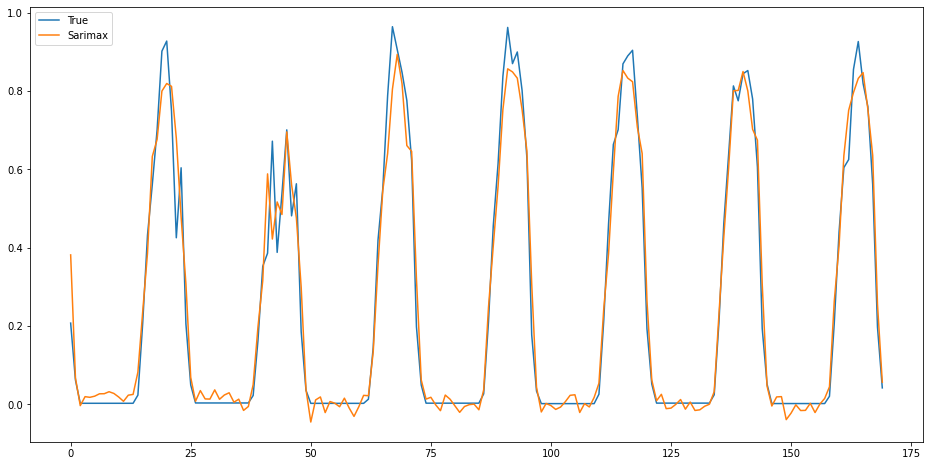

In [4]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

In [21]:
tr_ts_percents=[80,20]

In [22]:
ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12, prob_mut=0.8,
                                 tr_ts_percents=tr_ts_percents).search_best_model()
best_mlp_residual = ag_mlp_residual._best_of_all
pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

  0%|          | 0/3 [00:00<?, ?it/s]generation: 0

100%|██████████| 3/3 [00:21<00:00,  7.06s/it]

100%|██████████| 3/3 [00:33<00:00, 11.09s/it]

100%|██████████| 3/3 [00:07<00:00,  2.57s/it]

100%|██████████| 3/3 [00:50<00:00, 16.92s/it]

100%|██████████| 3/3 [00:12<00:00,  4.09s/it]

100%|██████████| 3/3 [00:21<00:00,  7.14s/it]

100%|██████████| 3/3 [00:28<00:00,  9.47s/it]

100%|██████████| 3/3 [00:17<00:00,  5.74s/it]

100%|██████████| 3/3 [00:10<00:00,  3.33s/it]

100%|██████████| 3/3 [00:54<00:00, 18.04s/it]

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]

100%|██████████| 3/3 [00:40<00:00, 13.44s/it]

100%|██████████| 3/3 [00:17<00:00,  5.71s/it]

100%|██████████| 3/3 [00:41<00:00, 13.71s/it]

100%|██████████| 3/3 [00:15<00:00,  5.13s/it]

100%|██████████| 3/3 [00:40<00:00, 13.65s/it]

100%|██████████| 3/3 [00:10<00:00,  3.44s/it]

100%|██████████| 3/3 [00:56<00:00, 18.98s/it]

100%|██████████| 3/3 [00:11<00:00,  3.87s/it]

100%|██████████| 3/3 [00:49<00:00, 16.64s/it]

100%|███

## Análise Resultados

[17, 19, 3, 16, MLPRegressor(activation='logistic', early_stopping=True,
             hidden_layer_sizes=(68, 44, 5), max_iter=500), MLPRegressor(early_stopping=True, hidden_layer_sizes=(18, 12, 8),
             learning_rate='adaptive', max_iter=500, solver='lbfgs'), 0.02432105552993146]
Teste para saber se pegou o melhor mesmo! 0.02432105552993146 == 0.02432105552993146 ?
True
Resultado Dados Teste!
SARIMAX
MAE:  0.035221778465560835
MSE:  0.0029411509830490398
MAPE:  2.9130356221922984
HIBRIDO
MAE:  0.02432105552993146
MSE:  0.001857770150767023
MAPE:  0.9090129264241429
GANHO MAE:
0.3094881465536412
GANHO MSE:
0.3683526750329883
GANHO MAPE:
0.6879499448963017


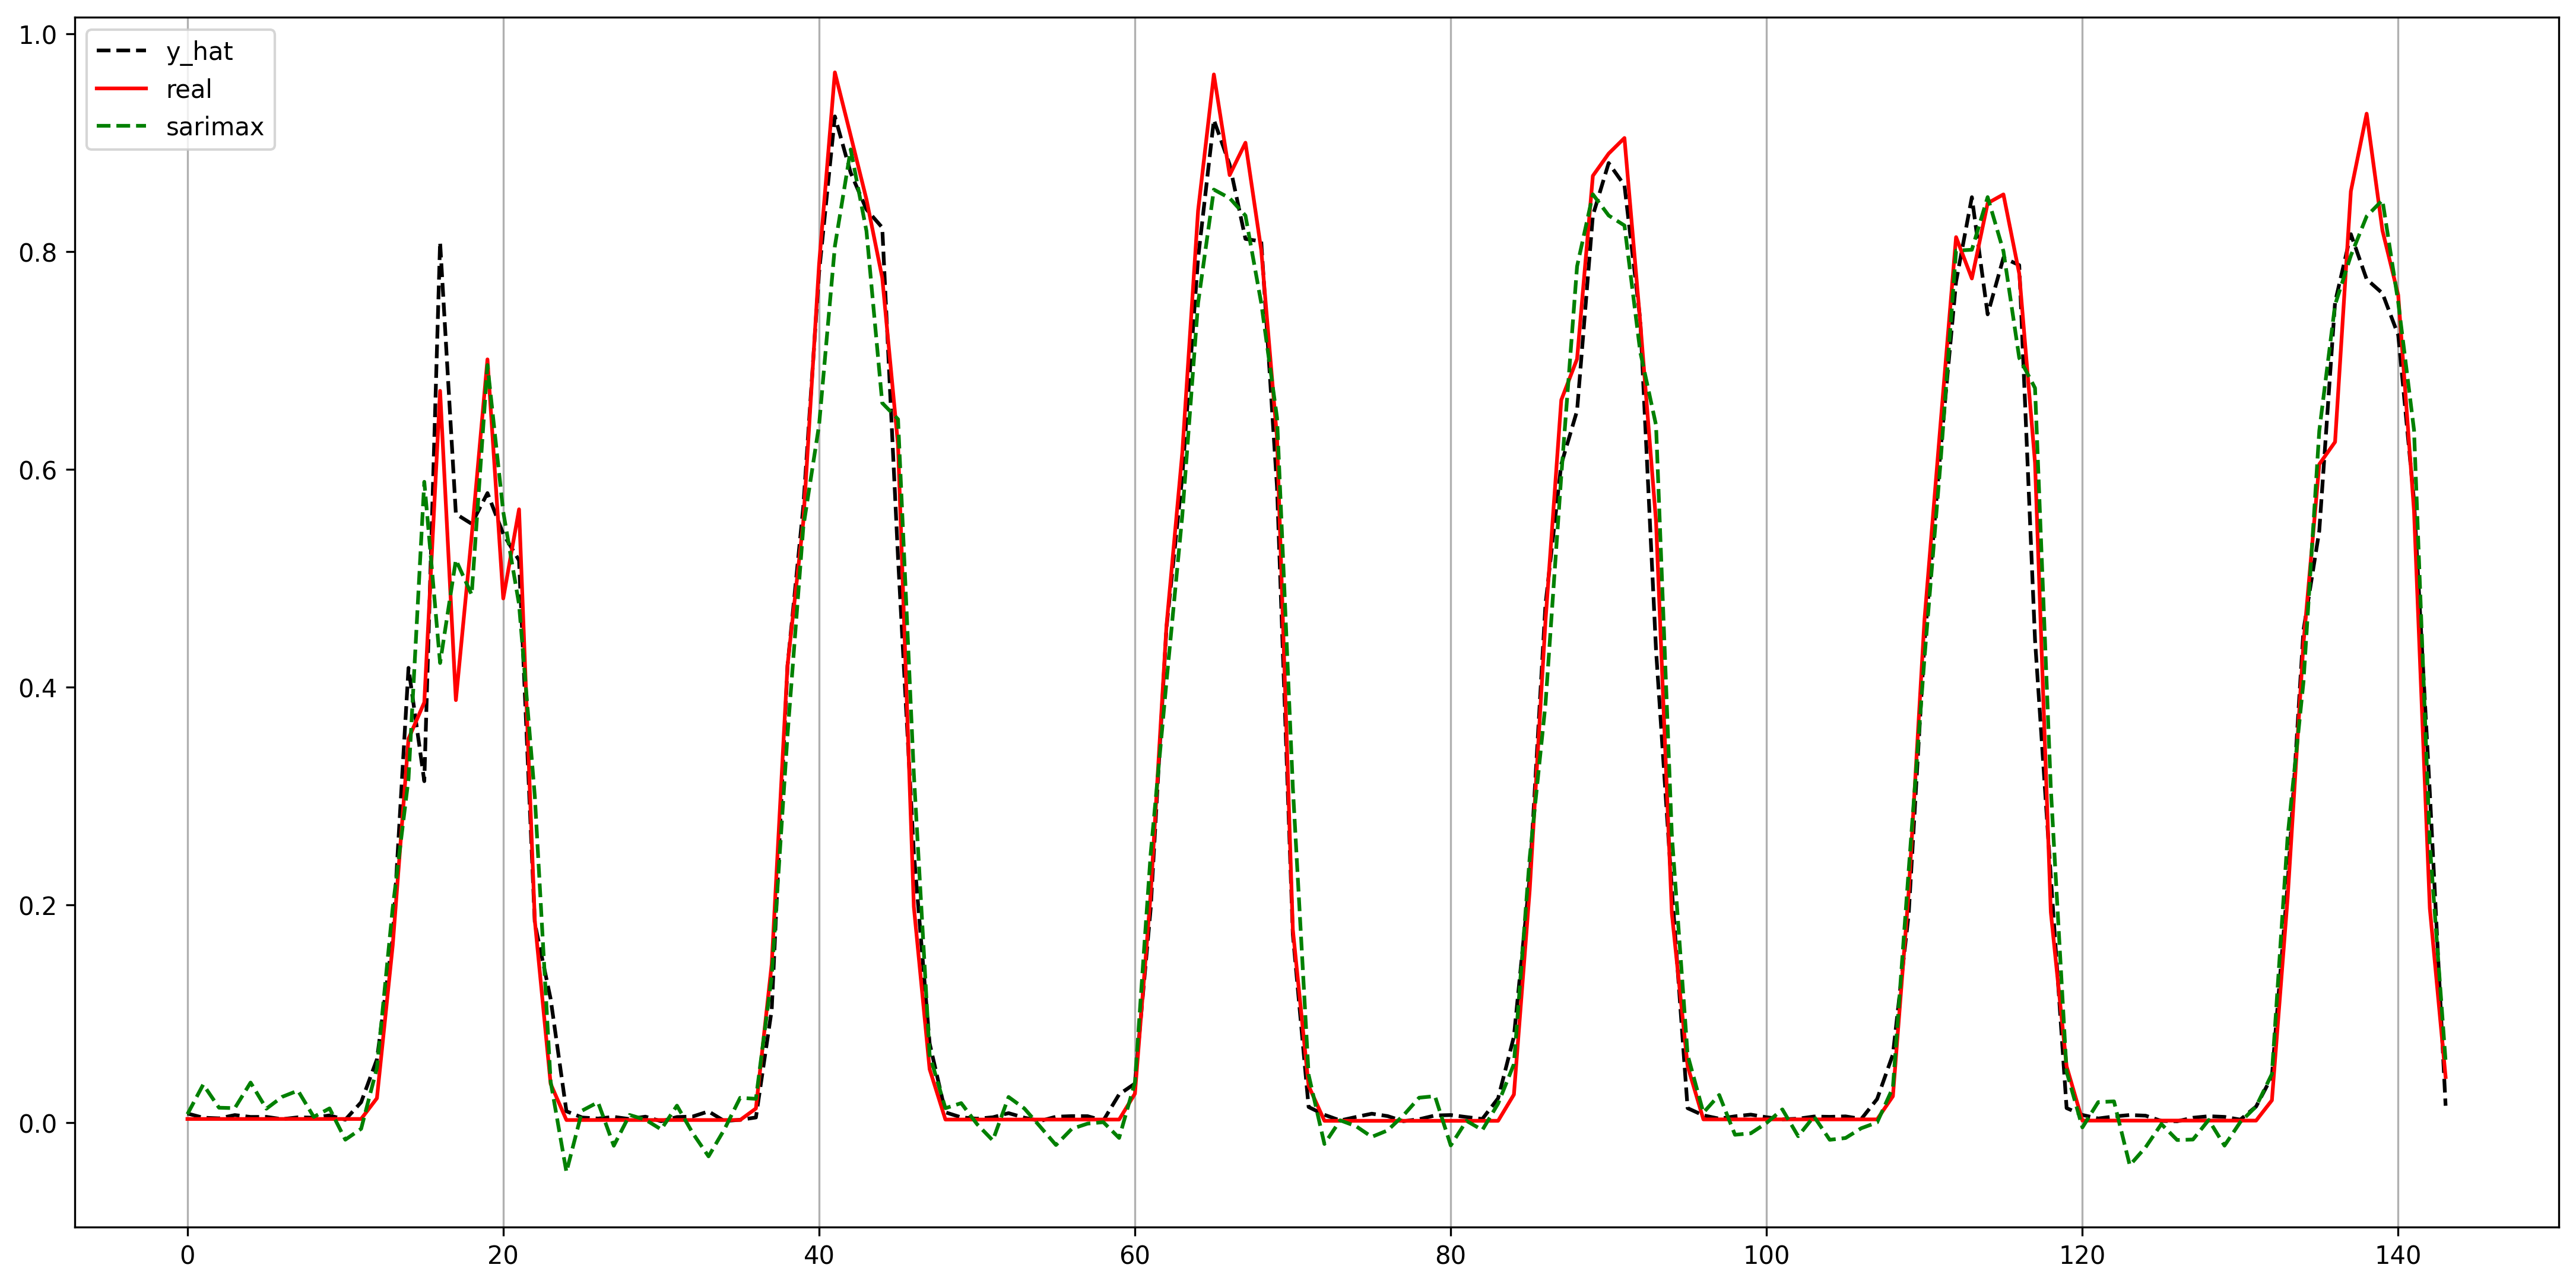

In [12]:
dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_all_residual = y_estimado_all
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

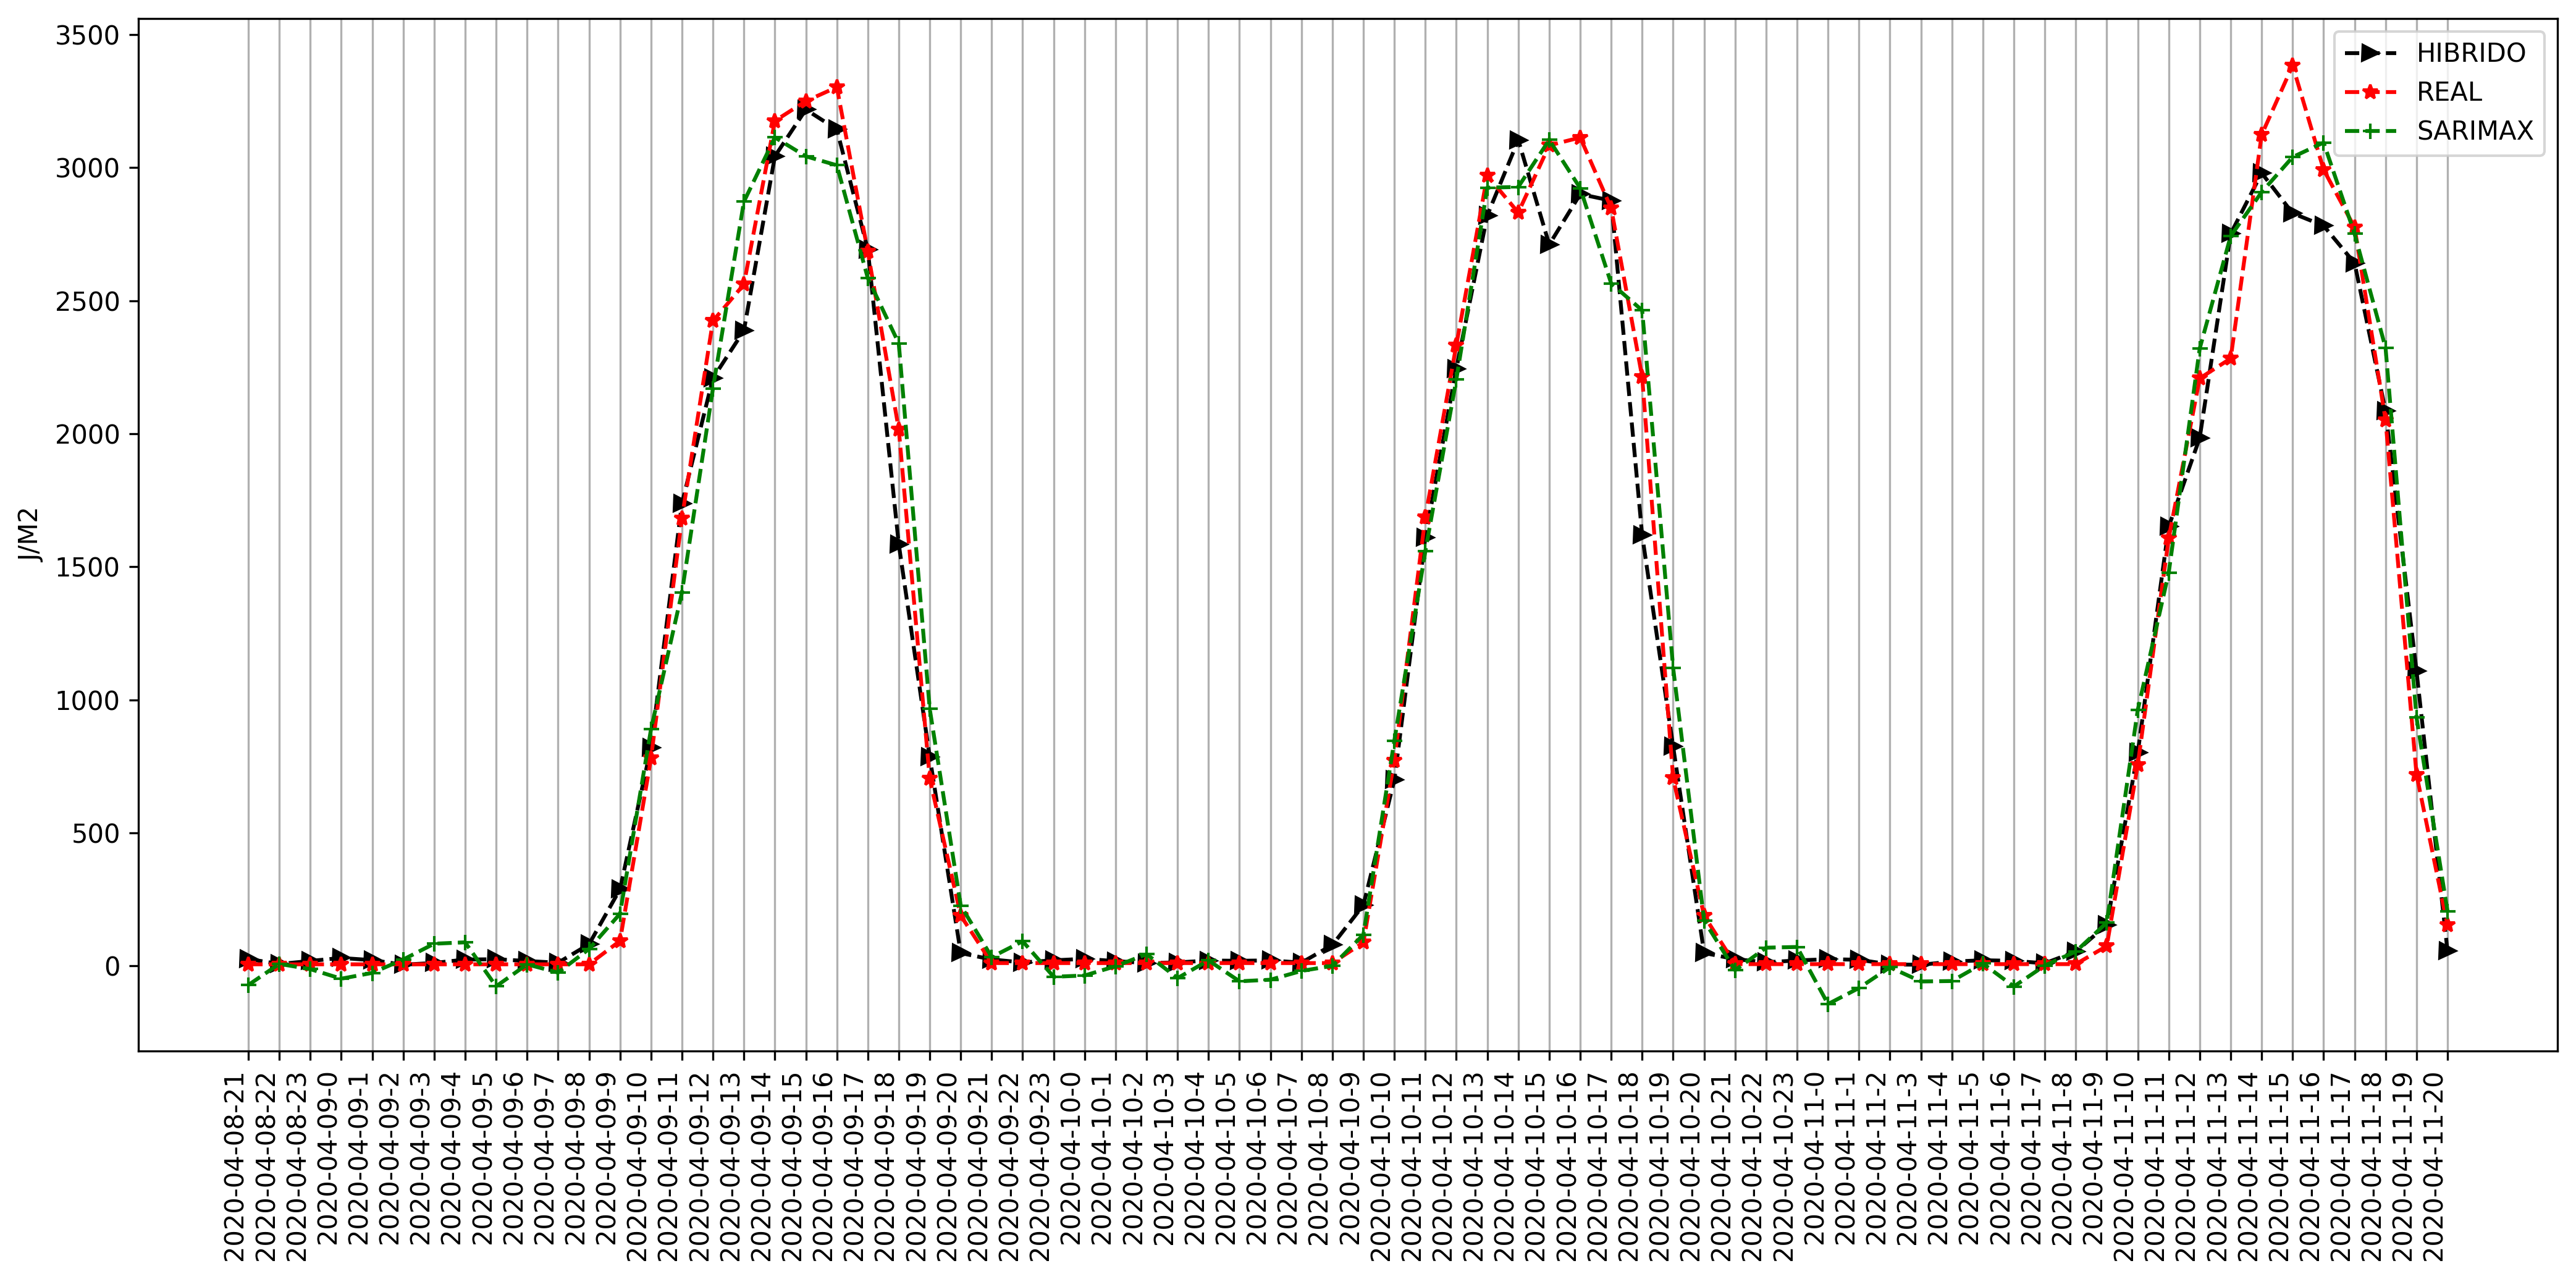

In [25]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-last_hours:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('J/M2', fontsize=10)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch3_pop12.png', dpi=300)

# Algoritmo AGMLP_VR_Residual

In [26]:
tr_ts_percents=[80,20]
ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 12,
                                       prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

start_set_fit: 0
  0%|          | 0/3 [00:00<?, ?it/s]generation: 0
start_set_fit: 0

100%|██████████| 3/3 [00:17<00:00,  5.90s/it]

100%|██████████| 3/3 [00:53<00:00, 17.69s/it]

100%|██████████| 3/3 [00:11<00:00,  3.90s/it]

100%|██████████| 3/3 [00:28<00:00,  9.37s/it]

100%|██████████| 3/3 [00:11<00:00,  3.84s/it]

100%|██████████| 3/3 [00:43<00:00, 14.42s/it]

100%|██████████| 3/3 [00:20<00:00,  6.99s/it]

100%|██████████| 3/3 [00:32<00:00, 10.83s/it]

100%|██████████| 3/3 [00:15<00:00,  5.25s/it]

100%|██████████| 3/3 [00:41<00:00, 13.72s/it]

100%|██████████| 3/3 [00:15<00:00,  5.08s/it]

100%|██████████| 3/3 [00:32<00:00, 10.71s/it]

100%|██████████| 3/3 [00:07<00:00,  2.60s/it]

100%|██████████| 3/3 [00:42<00:00, 14.27s/it]

100%|██████████| 3/3 [00:20<00:00,  6.97s/it]

100%|██████████| 3/3 [00:17<00:00,  5.90s/it]

100%|██████████| 3/3 [00:13<00:00,  4.55s/it]

100%|██████████| 3/3 [00:27<00:00,  9.16s/it]

100%|██████████| 3/3 [00:30<00:00, 10.29s/it]

100%|██████████| 3/3 

## Análise Resultados

[16, 16, 4, 16, 20, <mlopt.AgMlp.AgMlp object at 0x000001E22CDD34F0>, <mlopt.AgMlp.AgMlp object at 0x000001E22CE7FD00>, 0.026848473486150163]
Teste para saber se pegou o melhor mesmo! 0.026848473486150163 == <mlopt.AgMlp.AgMlp object at 0x000001E22CE7FD00> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.035221778465560835
MSE:  0.0029411509830490398
MAPE:  2.9130356221922984
HIBRIDO
MAE:  0.026848473486150163
MSE:  0.0024394409996036323
MAPE:  0.5304537873955746
GANHO MAE:
0.23773089674043368
GANHO MSE:
0.17058287260224003
GANHO MAPE:
0.8179034326410453


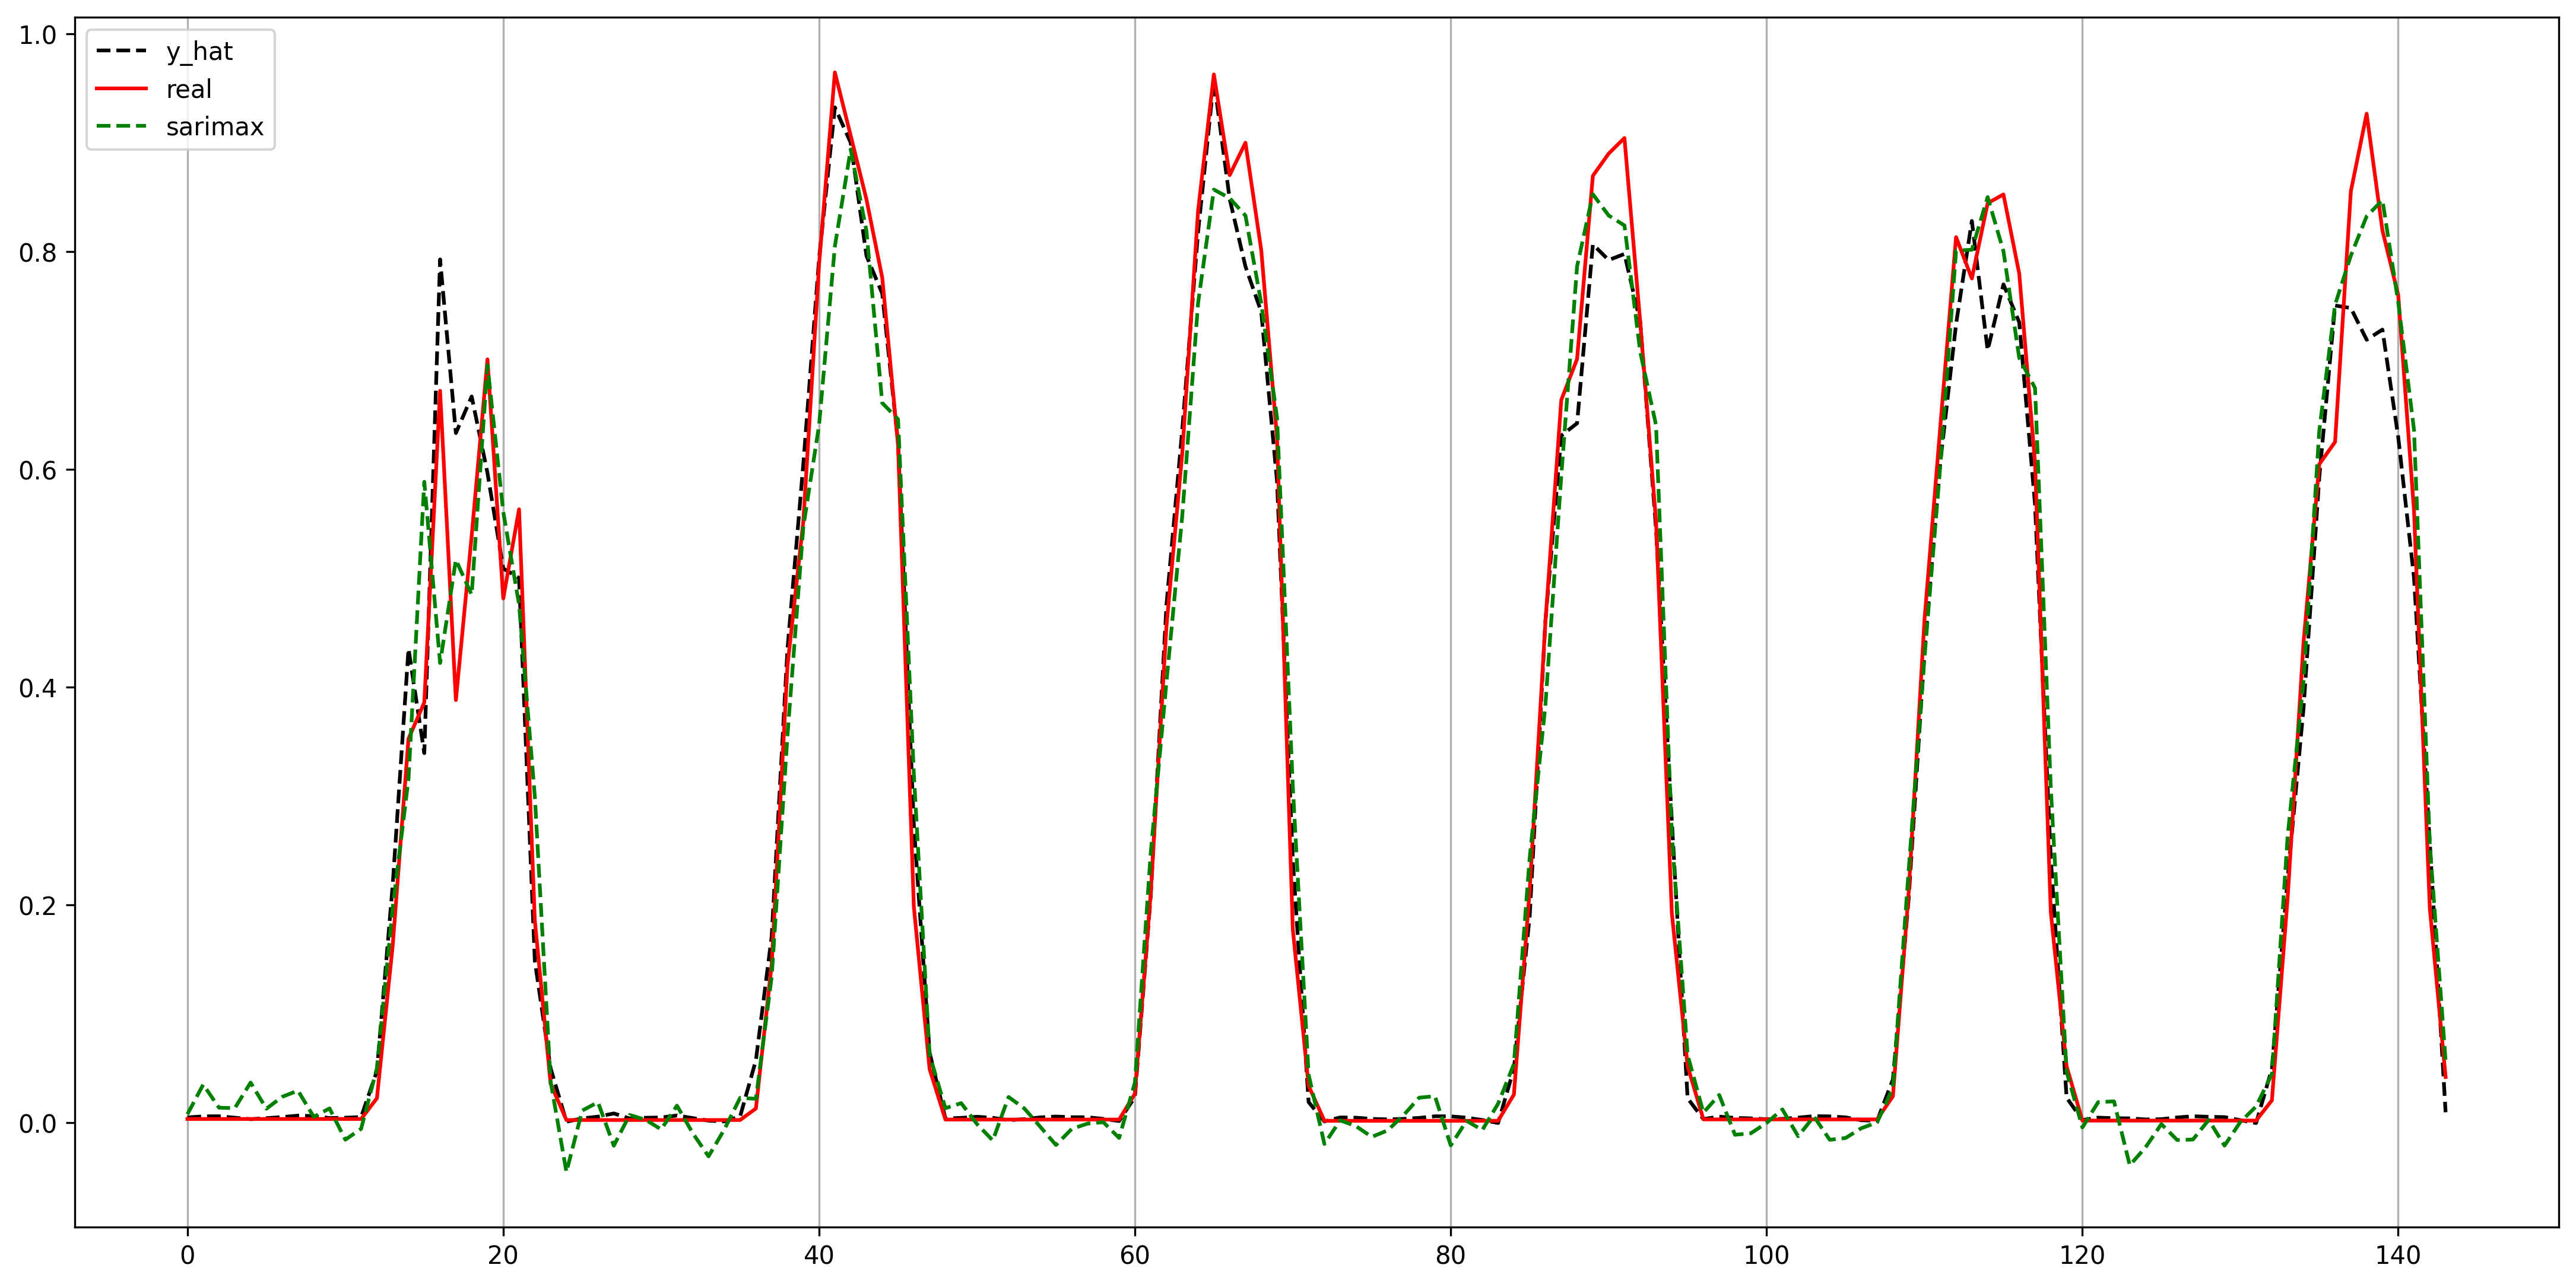

In [10]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

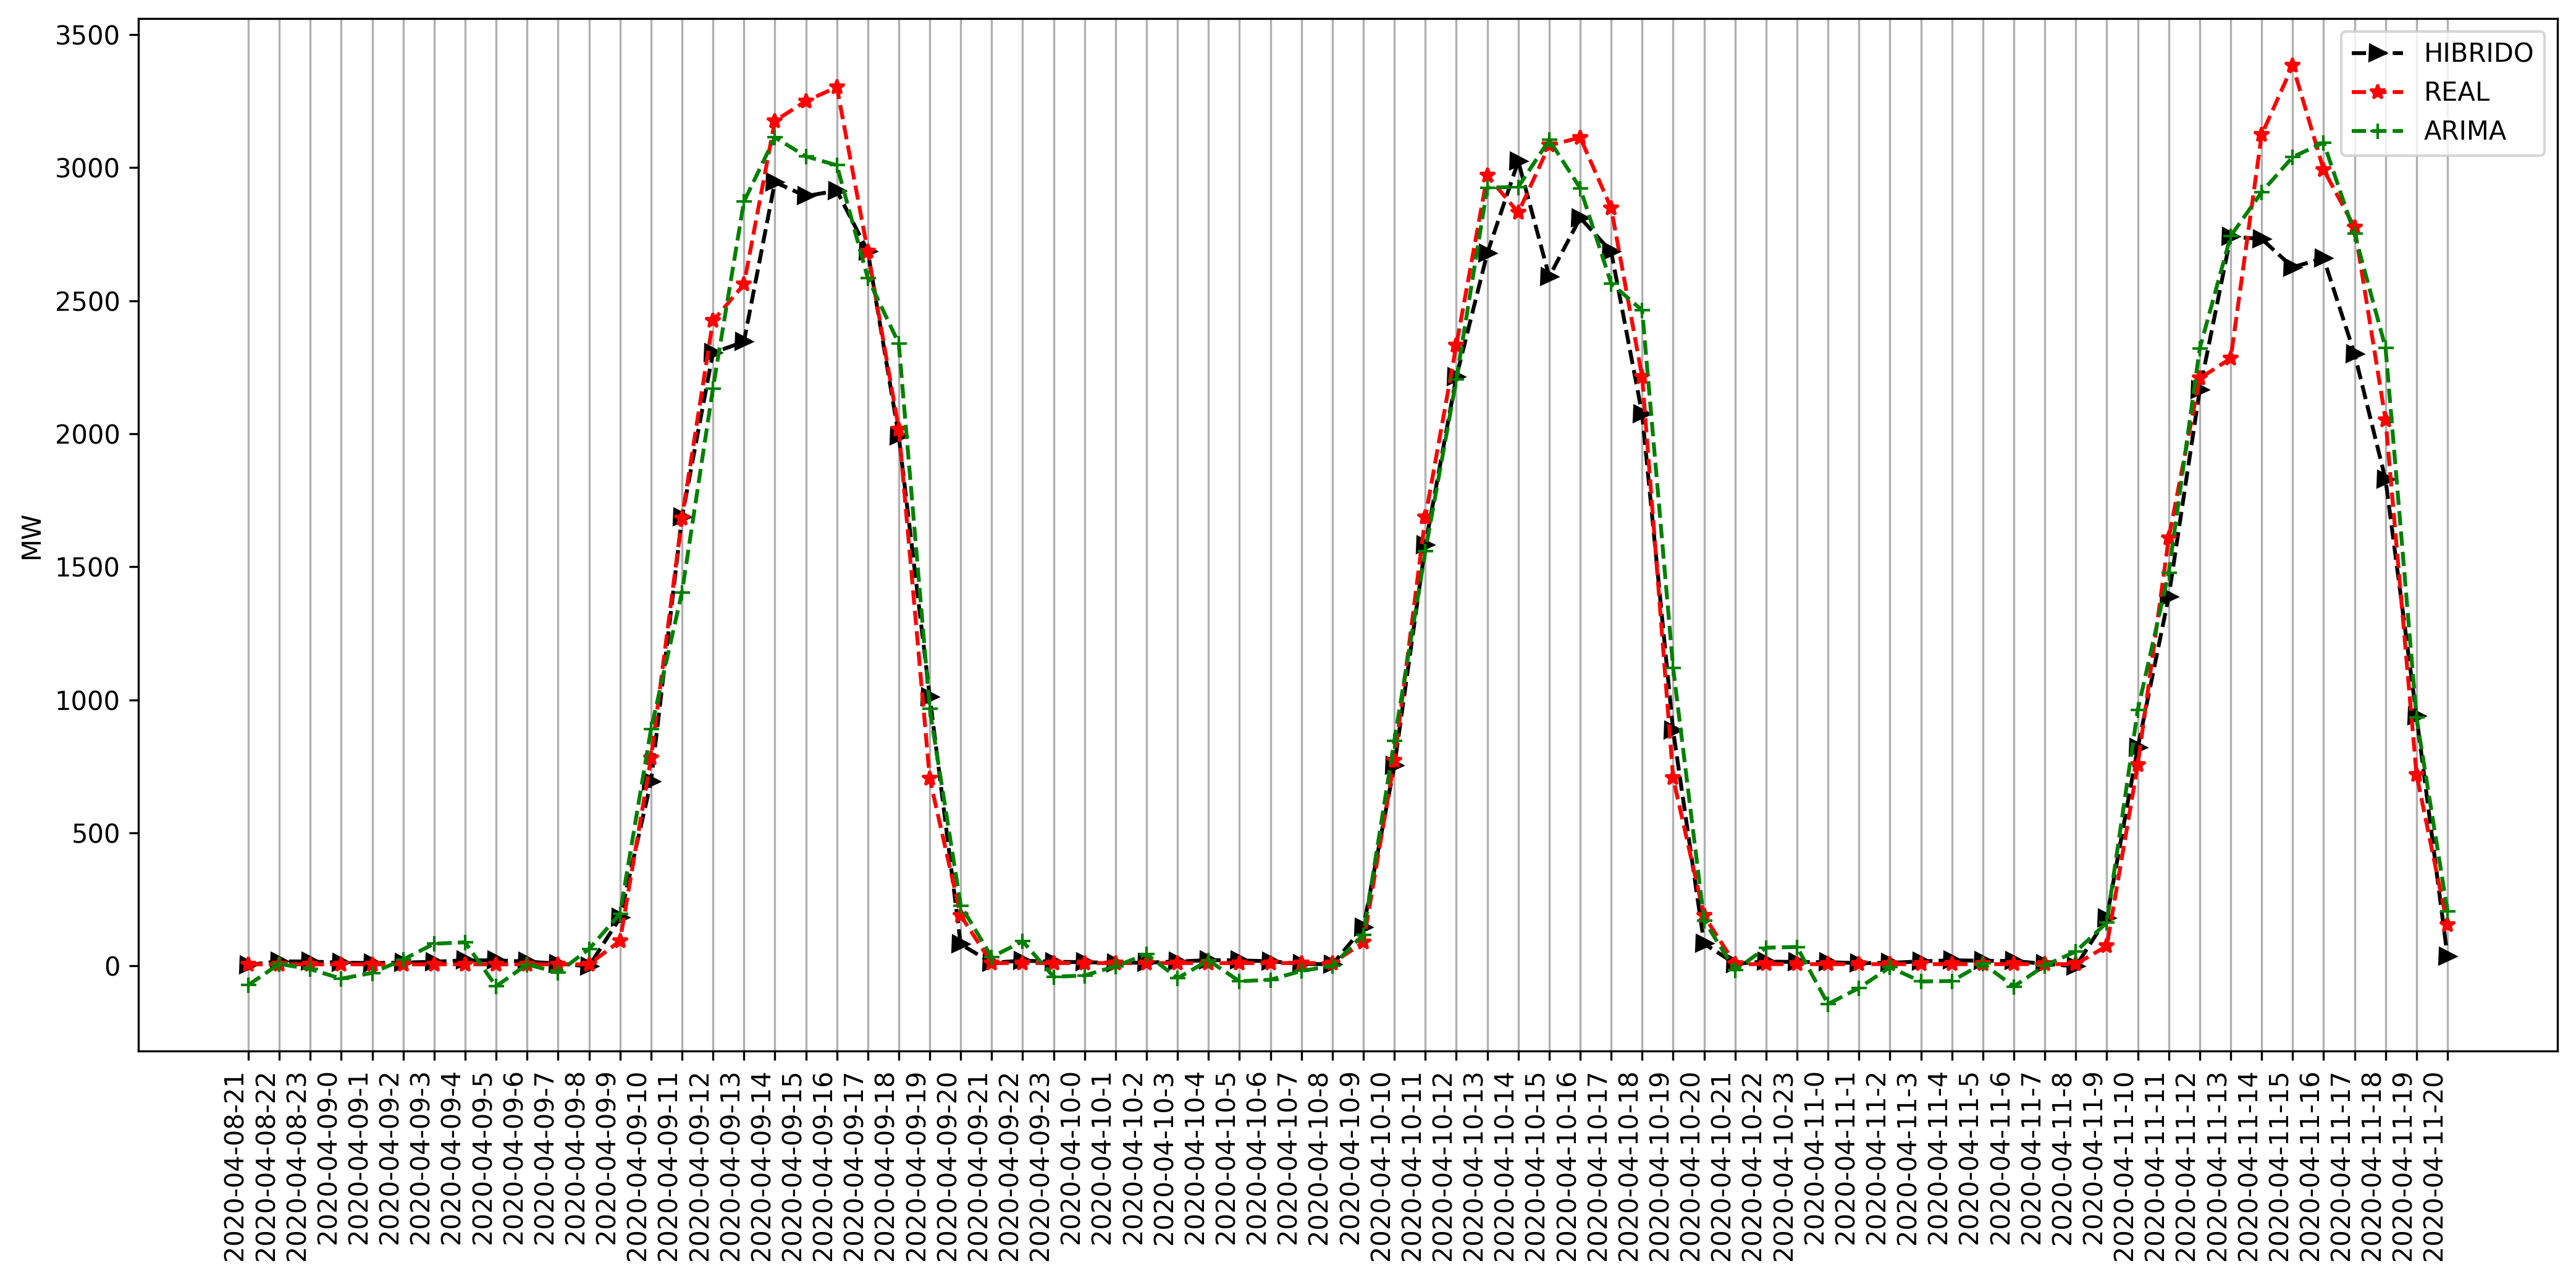

In [29]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-last_hours:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpvrresidual_epoch3_pop12.png', dpi=300)

# Figura Unica AG-MLP/AG-MLP-VR

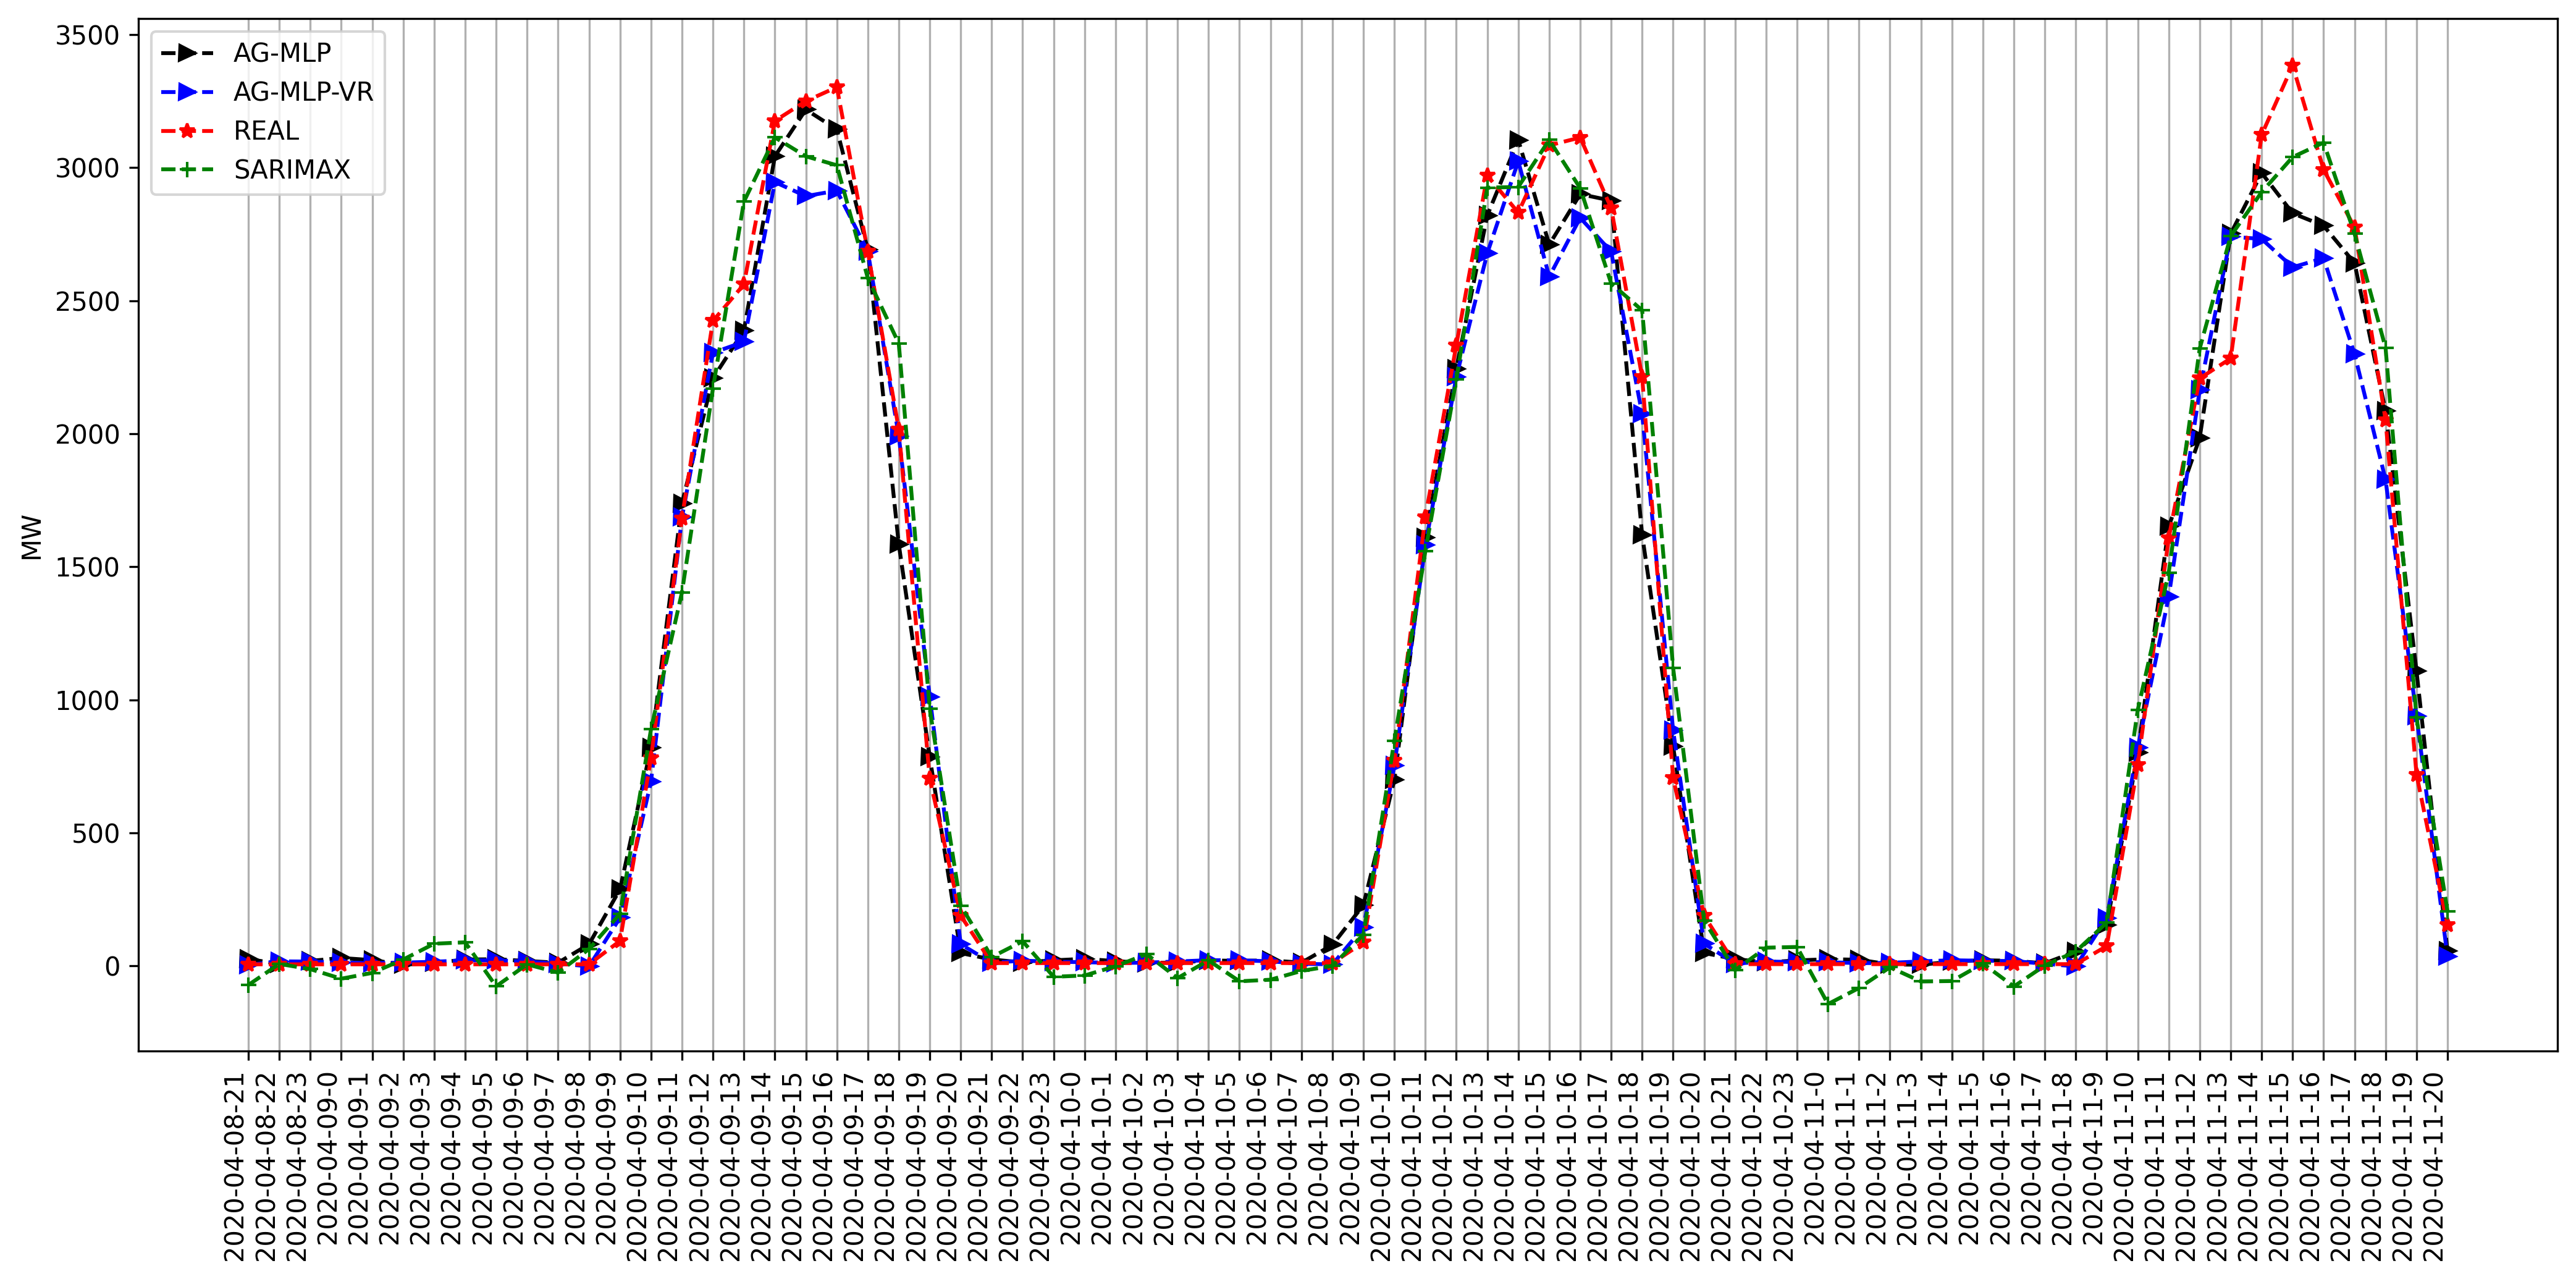

In [18]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_vr[-last_hours:].reshape(-1, 1)), 'k-->', label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_vr_residual[-last_hours:].reshape(-1, 1)), 'b-->', label='AG-MLP-VR')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids.png', dpi=300)

# Algoritmo AGEmsemble_Residual


[15, 10, 20, 1, VotingRegressor(estimators=[('SVR',
                             SVR(C=100, epsilon=0.1742386833465867,
                                 gamma='auto')),
                            ('BAG',
                             BaggingRegressor(max_samples=3, n_estimators=2)),
                            ('SGD', SGDRegressor()),
                            ('RFR',
                             RandomForestRegressor(max_depth=19,
                                                   min_samples_leaf=6,
                                                   min_weight_fraction_leaf=0.1315589727589142,
                                                   n_estimators=1)),
                            ('ADA', AdaBoostRegressor(n_estimators=38)),
                            ('LR', LinearRegression())]), VotingRegressor(estimators=[('RFR',
                             RandomForestRegressor(max_depth=7,
                                                   min_samples_leaf=4,
                        

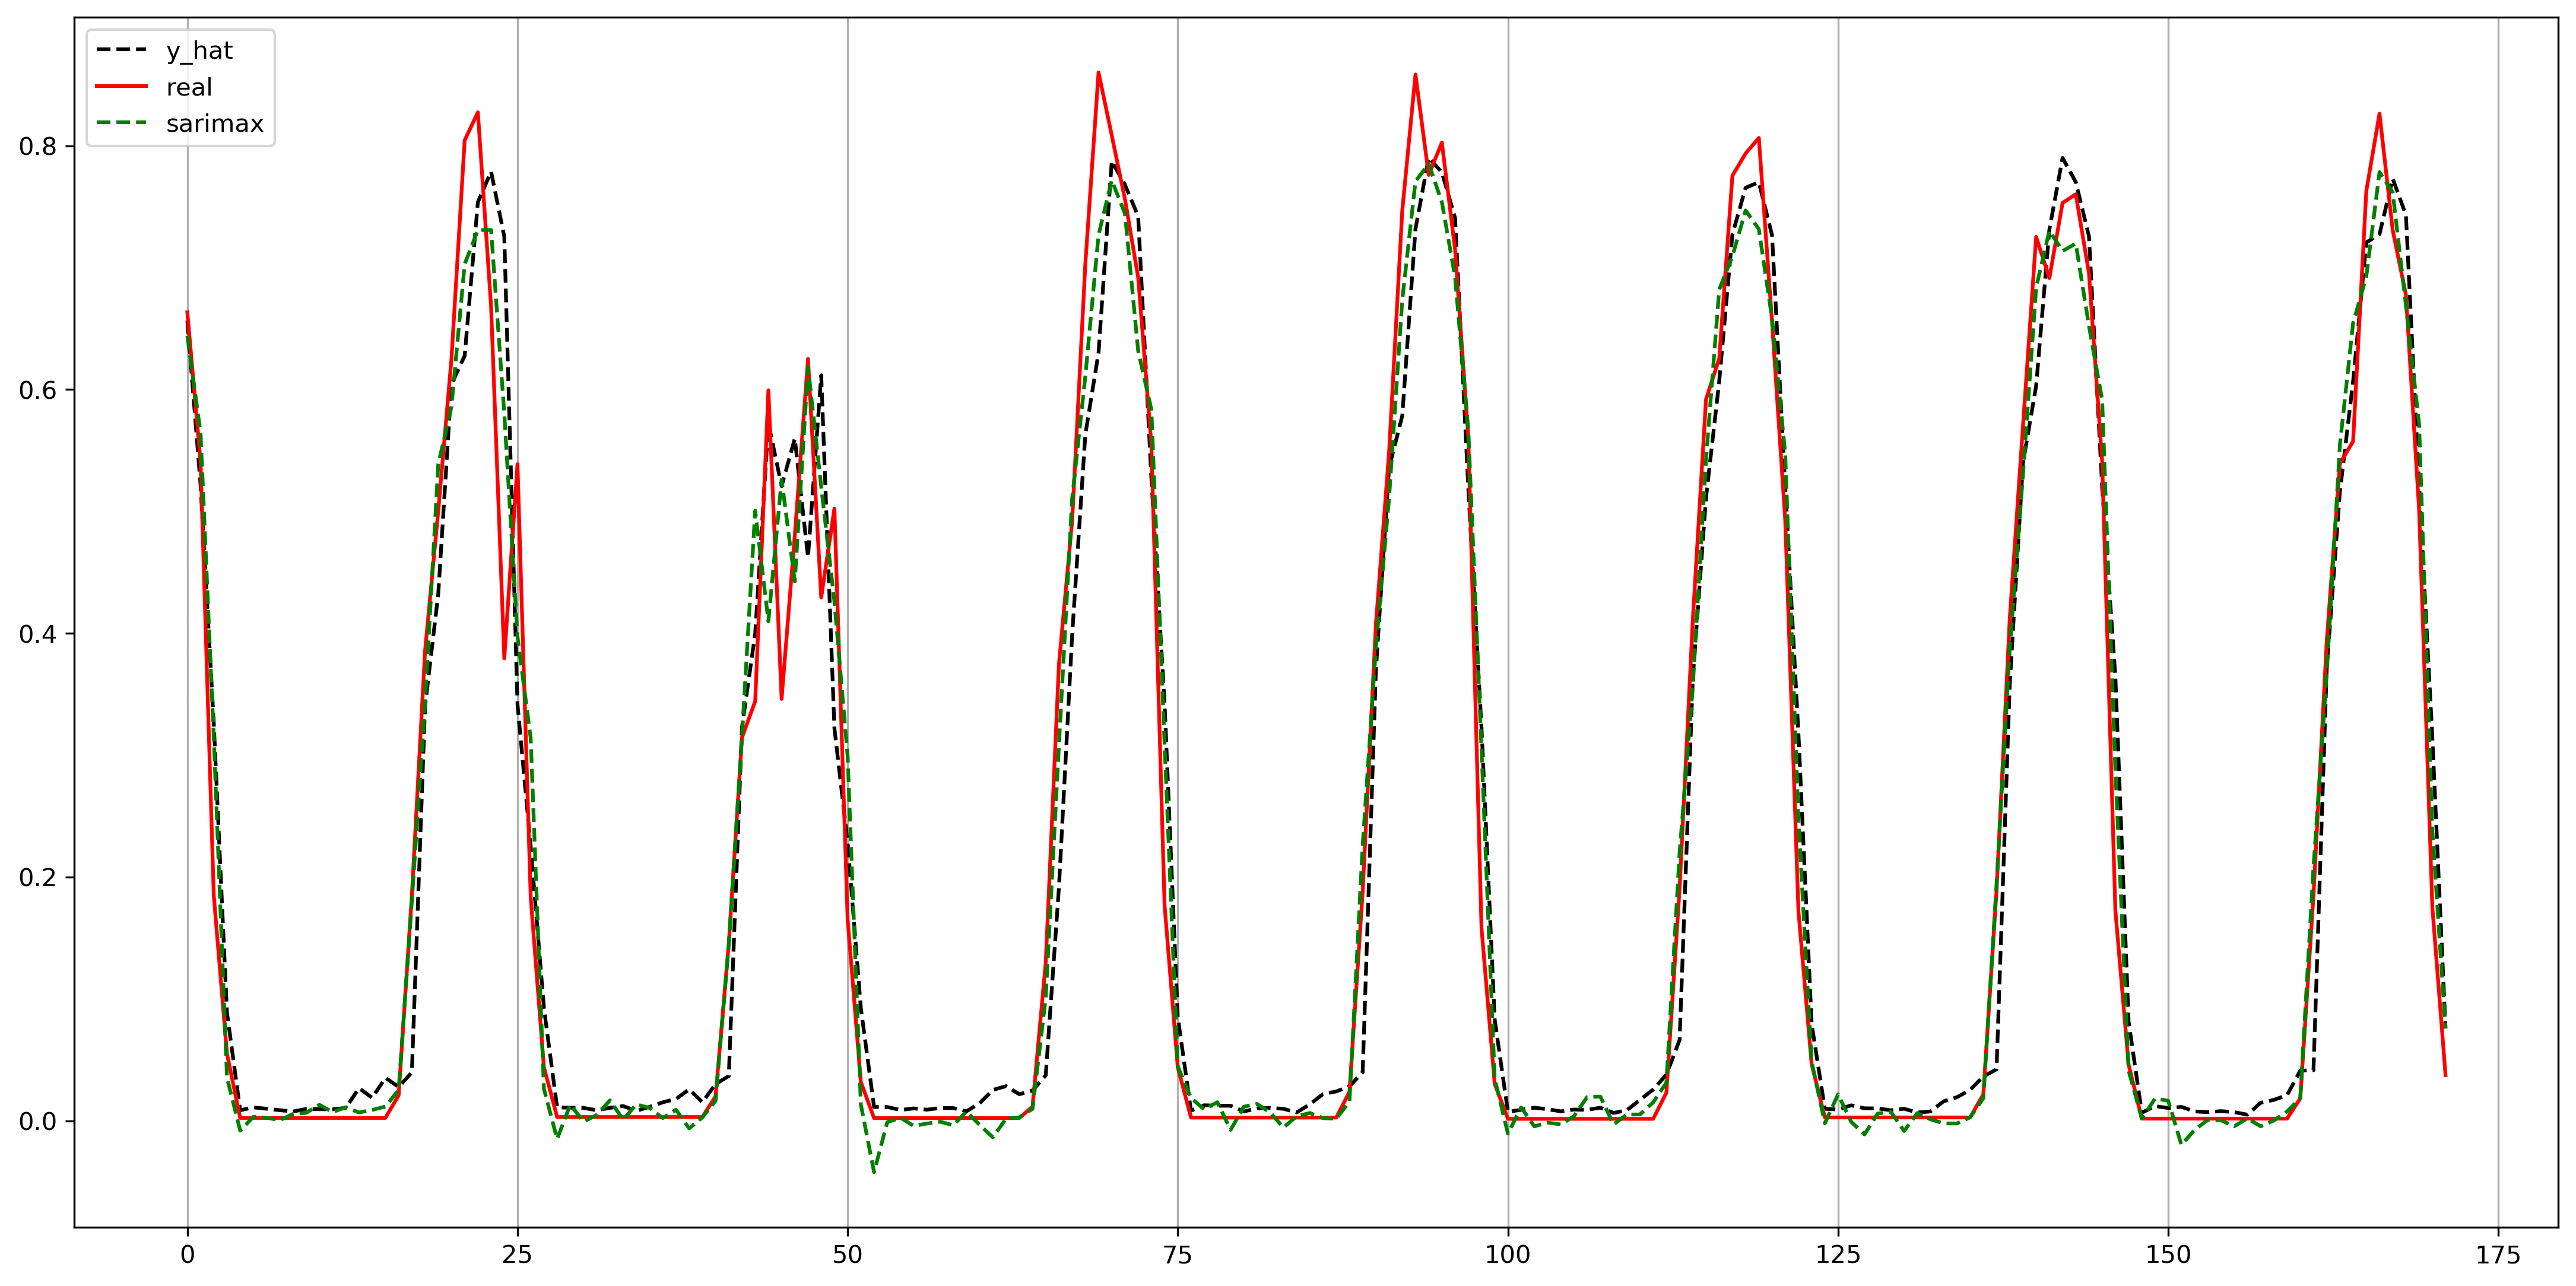

In [11]:
agensemble_residual = AGEnsemble_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 10,
                                       prob_mut=0.5, tr_ts_percents=[80,20]).search_best_model()

best_agensemble_residual = agensemble_residual._best_of_all

pickle.dump(best_agensemble_residual, open('best_model_AGEmsemble_RESIDUAL.pckl', 'wb'))

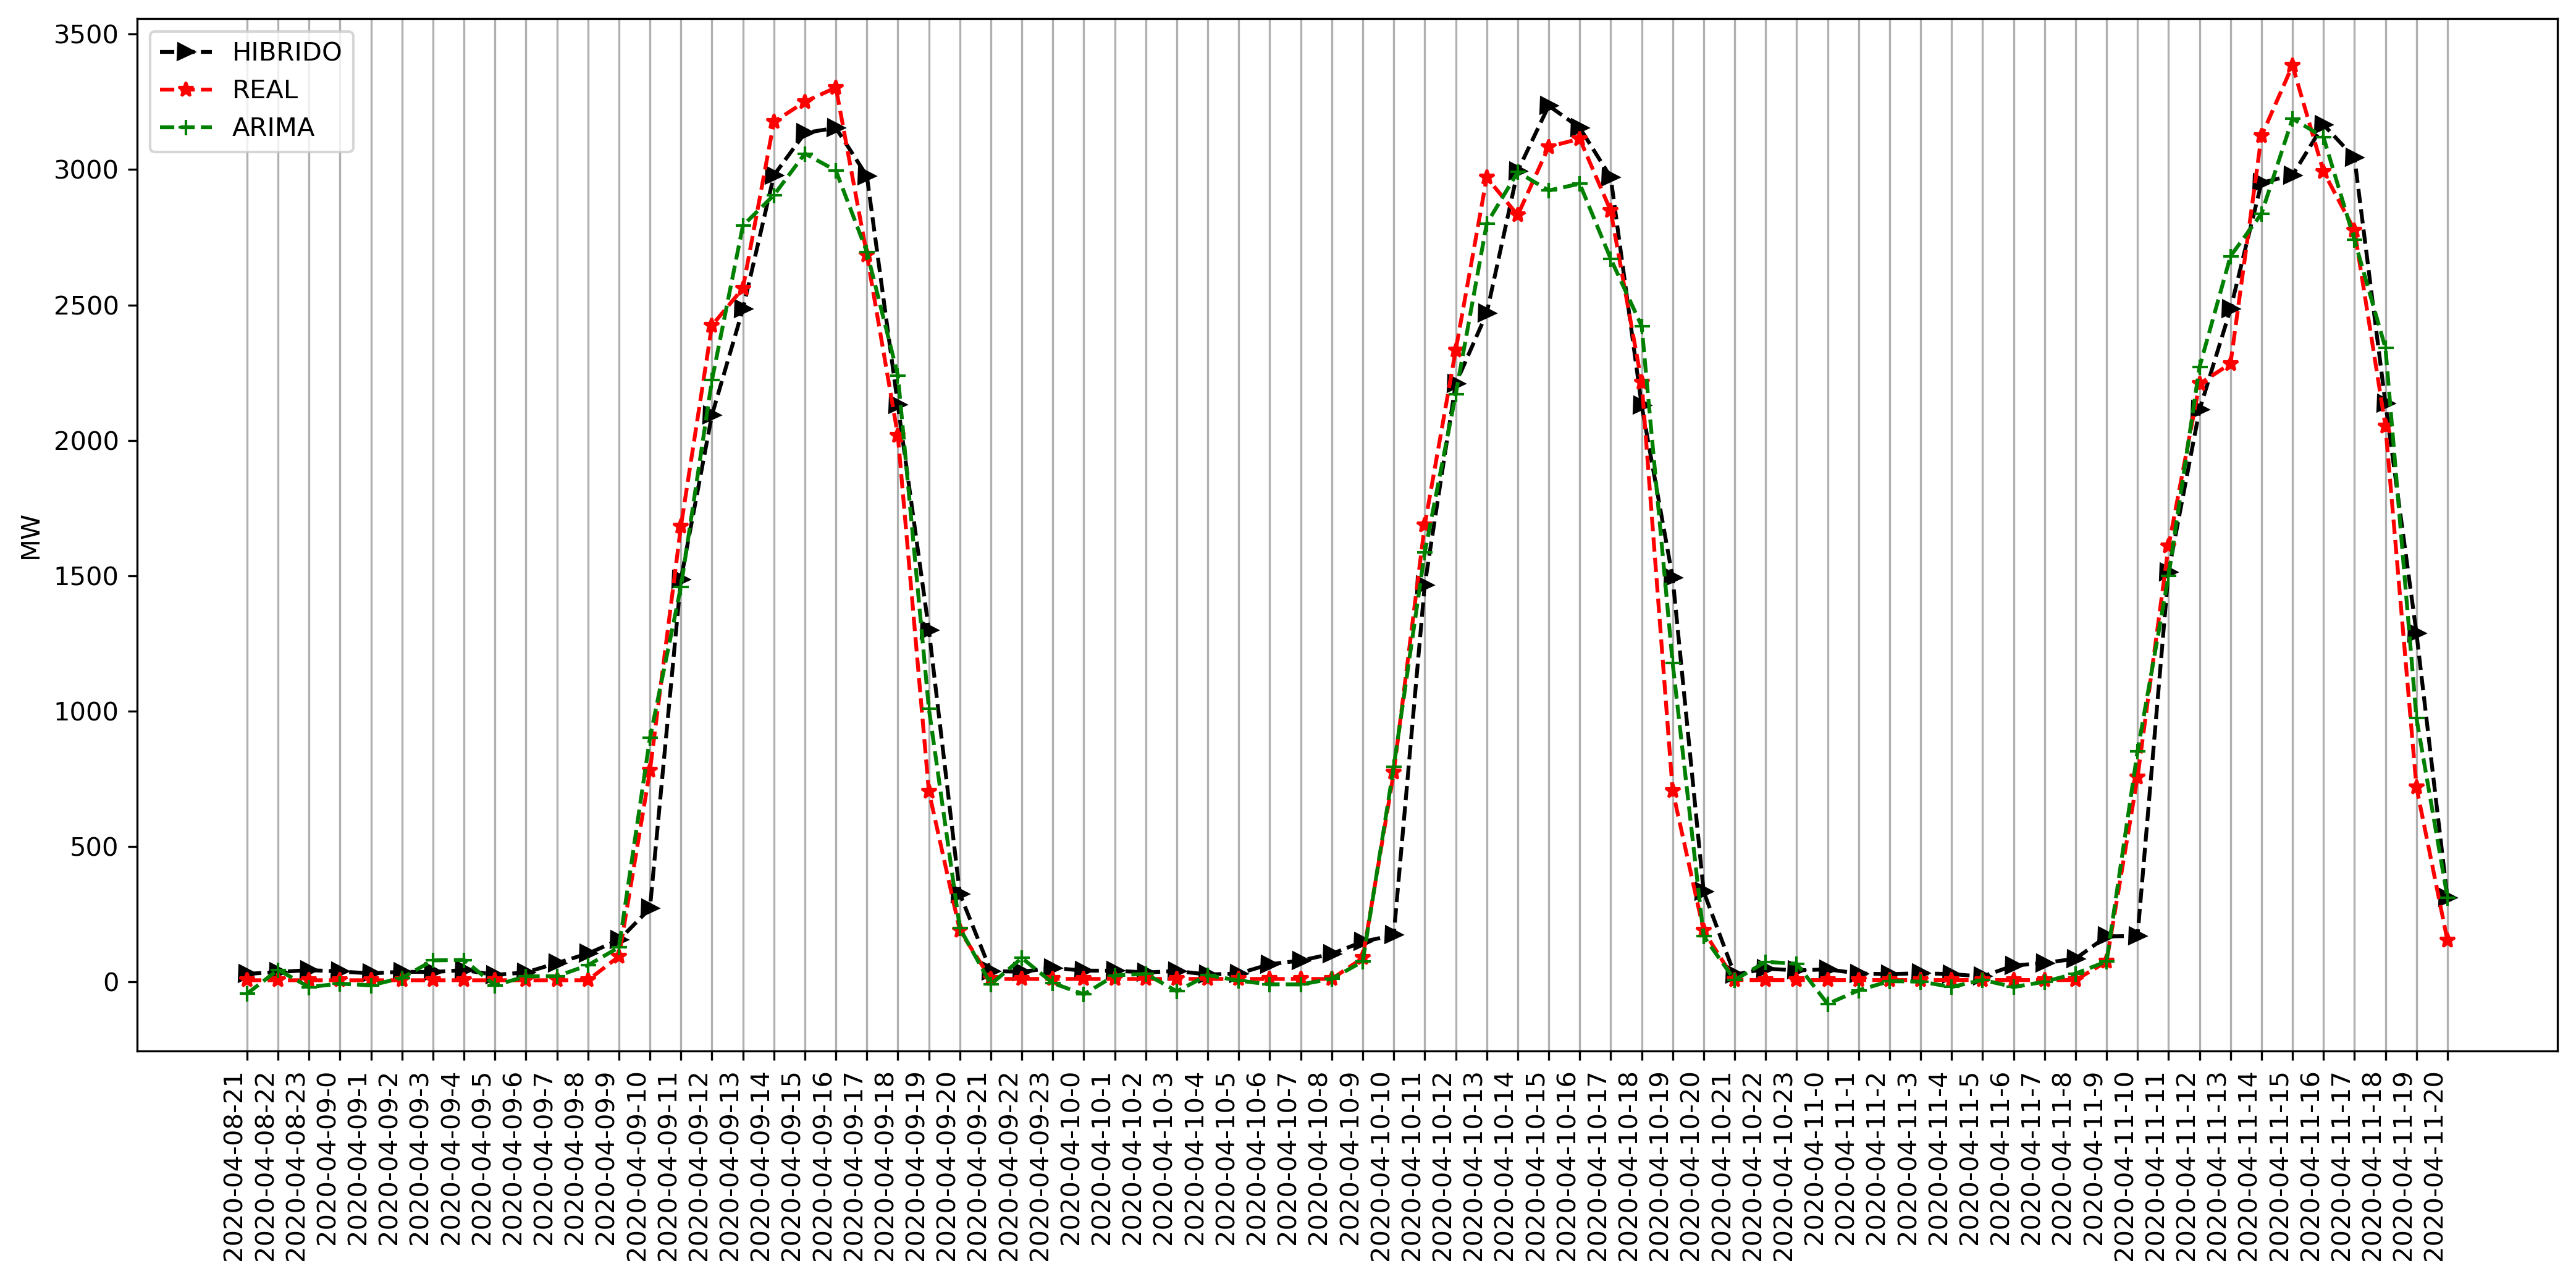

In [14]:
## Análise Resultados

In [ ]:
dict_series = pickle.load(open('dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('best_model_AGEmsemble_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

threshold = int(len(y_sarimax)*0.8)

data_train = gen[0:threshold]
data_test = gen[threshold:]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], [80, 20])
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], [80, 20])
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt/10)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()